In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras, sys, time, os, warnings,  cv2
from keras.models import *
from keras.layers import *

import numpy as np
import pandas as pd 

In [2]:
FTRAIN = "data/training.csv"
FTEST  = "data/test.csv"
FIdLookup = 'data/IdLookupTable.csv'

In [3]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,landmarks,s=3):
        """ Generate a full Heap Map for every landmarks in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
            joints    : [(x1,y1),(x2,y2)...] containing landmarks
            maxlenght : Lenght of the Bounding Box
        """
        Nlandmarks = len(landmarks)
        hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
        for i in range(Nlandmarks):
            if not np.array_equal(landmarks[i], [-1,-1]):
             
                hm[:,:,i] = gaussian_k(landmarks[i][0],
                                        landmarks[i][1],
                                        s,height, width)
            else:
                hm[:,:,i] = np.zeros((height,width))
        return hm
    
def get_y_as_heatmap(df,height,width, sigma):
    
    columns_lmxy = df.columns[:-1] ## the last column contains Image
    columns_lm = [] 
    for c in columns_lmxy:
        c = c[:-2]
        if c not in columns_lm:
            columns_lm.extend([c])
    
    y_train = []
    for i in range(df.shape[0]):
        landmarks = []
        for colnm in columns_lm:
            x = df[colnm + "_x"].iloc[i]
            y = df[colnm + "_y"].iloc[i]
            if np.isnan(x) or np.isnan(y):
                x, y = -1, -1
            landmarks.append([x,y])
            
        y_train.append(generate_hm(height, width, landmarks, sigma))
    y_train = np.array(y_train)
    
    
    return(y_train,df[columns_lmxy],columns_lmxy)

In [4]:
def load(test=False, width=96,height=96,sigma=5):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X:  2-d numpy array (Nsample, Ncol*Nrow)
    y:  2-d numpy array (Nsample, Nlandmarks*2) 
        In total there are 15 landmarks. 
        As x and y coordinates are recorded, u.shape = (Nsample,30)
    y0: panda dataframe containins the landmarks
       
    """
    from sklearn.utils import shuffle
    
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname)) 

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))


    myprint = df.count()
    myprint = myprint.reset_index() 
    ## row with at least one NA columns are removed!
    ## df = df.dropna()  
    df = df.fillna(-1)

    X = np.vstack(df['Image'].values) / 255.  # changes valeus between 0 and 1
    X = X.astype(np.float32)

    if not test:  # labels only exists for the training data
        y, y0, nm_landmark = get_y_as_heatmap(df,height,width, sigma)
        X, y, y0 = shuffle(X, y, y0, random_state=42)  # shuffle data   
        y = y.astype(np.float32)
    else:
        y, y0, nm_landmark = None, None, None
    
    return X, y, y0, nm_landmark

def load2d(test=False,width=96,height=96,sigma=5):

    re   = load(test,width,height,sigma)
    X    = re[0].reshape(-1,width,height,1)
    y, y0, nm_landmarks = re[1:]
    
    return X, y, y0, nm_landmarks

In [5]:
sigma = 5

X_train, y_train, y_train0, nm_landmarks = load2d(test=False,sigma=sigma)
X_test,  y_test, _, _ = load2d(test=True,sigma=sigma)
print(X_train.shape,y_train.shape, y_train0.shape)
print(X_test.shape,y_test)

(7049, 96, 96, 1) (7049, 96, 96, 15) (7049, 30)
(1783, 96, 96, 1) None


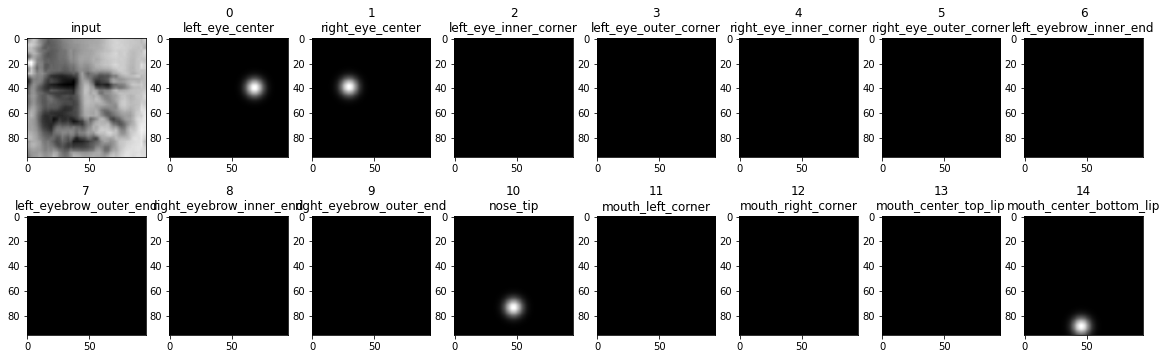

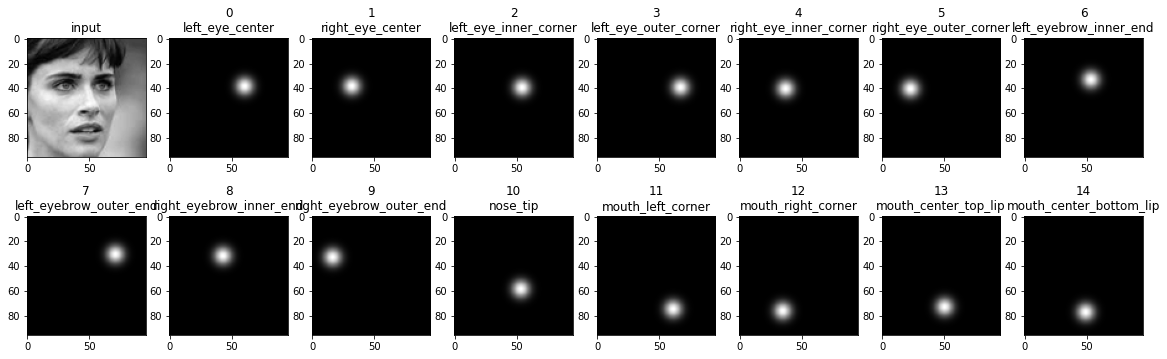

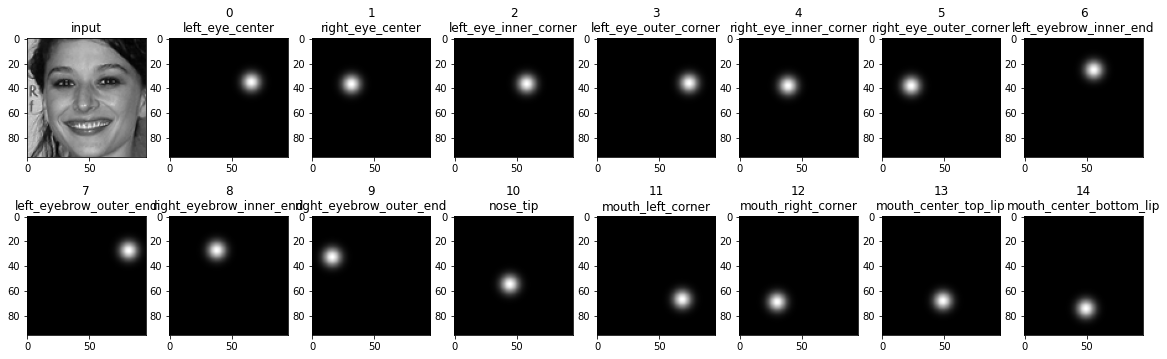

In [6]:
Nplot = y_train.shape[3]+1

for i in range(3):
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(2,Nplot//2,1)
    ax.imshow(X_train[i,:,:,0],cmap="gray")
    ax.set_title("input")
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nplot//2,j+2)
        ax.imshow(y_train[i,:,:,j],cmap="gray")
        ax.set_title(str(j) +"\n" + lab[:-2] )
    plt.show()

In [7]:
prop_train = 0.7
Ntrain = int(X_train.shape[0]*prop_train)
X_train = X_train[:Ntrain]
y_train = y_train[:Ntrain]
Ntrain = int(X_train.shape[0]*0.9)
X_tra, y_tra, X_val,y_val = X_train[:Ntrain],y_train[:Ntrain],X_train[Ntrain:],y_train[Ntrain:]
del X_train, y_train

In [8]:
input_height, input_width = 96, 96
## output shape is the same as input
output_height, output_width = input_height, input_width 
n = 32*5
nClasses = 15
nfmp_block1 = 64
nfmp_block2 = 128

IMAGE_ORDERING =  "channels_last" 
img_input = Input(shape=(input_height,input_width, 1)) 

# Encoder Block 1
x = Conv2D(nfmp_block1, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
x = Conv2D(nfmp_block1, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
block1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    
# Encoder Block 2
x = Conv2D(nfmp_block2, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(block1)
x = Conv2D(nfmp_block2, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    
## bottoleneck    
o = (Conv2D(n, (input_height//4, input_width//4), 
            activation='relu' , padding='same', name="bottleneck_1", data_format=IMAGE_ORDERING))(x)
o = (Conv2D(n , ( 1 , 1 ) , activation='relu' , padding='same', name="bottleneck_2", data_format=IMAGE_ORDERING))(o)

## Decoder Block
## upsampling to bring the feature map size to be the same as the input image i.e., heatmap size
output   = Conv2DTranspose(nClasses,    kernel_size=(4,4),  strides=(4,4), use_bias=False, name='upsample_2', data_format=IMAGE_ORDERING )(o)

## Reshaping is necessary to use sample_weight_mode="temporal" which assumes 3 dimensional output shape
## See below for the discussion of weights
output = Reshape((output_width*input_height*nClasses,1))(output)
model = Model(img_input, output)
model.summary()

model.compile(loss='mse',optimizer="rmsprop",sample_weight_mode="temporal")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [9]:
def find_weight(y_tra):
    '''
    :::input:::
    
    y_tra : np.array of shape (N_image, height, width, N_landmark)
    
    :::output::: 
    
    weights : 
        np.array of shape (N_image, height, width, N_landmark)
        weights[i_image, :, :, i_landmark] = 1 
                        if the (x,y) coordinate of the landmark for this image is recorded.
        else  weights[i_image, :, :, i_landmark] = 0

    '''
    weight = np.zeros_like(y_tra)
    count0, count1 = 0, 0
    for irow in range(y_tra.shape[0]):
        for ifeat in range(y_tra.shape[-1]):
            if np.all(y_tra[irow,:,:,ifeat] == 0):
                value = 0
                count0 += 1
            else:
                value = 1
                count1 += 1
            weight[irow,:,:,ifeat] = value
    print("N landmarks={:5.0f}, N missing landmarks={:5.0f}, weight.shape={}".format(
        count0,count1,weight.shape))
    return(weight)


def flatten_except_1dim(weight,ndim=2):
    '''
    change the dimension from:
    (a,b,c,d,..) to (a, b*c*d*..) if ndim = 2
    (a,b,c,d,..) to (a, b*c*d*..,1) if ndim = 3
    '''
    n = weight.shape[0]
    if ndim == 2:
        shape = (n,-1)
    elif ndim == 3:
        shape = (n,-1,1)
    else:
        print("Not implemented!")
    weight = weight.reshape(*shape)
    return(weight)

In [10]:
y_val_fla  = flatten_except_1dim(y_val,ndim=3) 

print("y_val_fla.shape={}".format(y_val_fla.shape))
print(model.output.shape)

y_val_fla.shape=(494, 138240, 1)
(None, 138240, 1)


In [11]:
# If you want no data augementation, comment out the line above and uncomment the comment below:
# x_batch, y_batch = X_tra, y_tra

# w_batch_fla = flatten_except_1dim(w_batch,ndim=2)
y_batch_fla = flatten_except_1dim(y_tra,ndim=3)

In [12]:
##### load the weights #####
# model.load_weights('./model_checkpoints/best')  # best or last
# print('train')
# model.evaluate(X_tra, y_batch_fla, verbose=2)
# print('test')
# model.evaluate(X_val, y_val_fla*const, verbose=2)
# None

In [13]:
nb_epochs = 100 # 100
batch_size = 8
const = 10 

cp_callback_best = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/best', save_weights_only=True, save_best_only=True, verbose=1)
cp_callback_last = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/last', save_weights_only=True, save_best_only=False, verbose=1)

print(y_batch_fla.shape)
hist = model.fit(X_tra,
                 y_batch_fla*const,
                 validation_data=(X_val,y_val_fla*const),
                 batch_size=batch_size,
                 epochs=nb_epochs,
                 verbose=1,
                 callbacks=[cp_callback_best, cp_callback_last])


# nb_epochs = 100
# batch_size = 1
# const = 10 
# history = {"loss":[],"val_loss":[]}
# for iepoch in range(nb_epochs):
#     start = time.time()

#     y_batch_fla = flatten_except_1dim(y_tra,ndim=3)
    
#     hist = model.fit(X_tra,
#                      y_batch_fla*const,
#                      validation_data=(X_val,y_val_fla*const),
#                      batch_size=batch_size,
#                      epochs=1,
#                      verbose=0)
#     history["loss"].append(hist.history["loss"][0])
#     history["val_loss"].append(hist.history["val_loss"][0])
#     end = time.time()
#     print("Epoch {:03}: loss {:6.4f} val_loss {:6.4f} {:4.1f}sec".format(
#         iepoch+1,history["loss"][-1],history["val_loss"][-1],end-start))

(4440, 138240, 1)
Epoch 1/100
555/555 [==============================] - ETA: 0s - loss: 0.2389
Epoch 1: val_loss improved from inf to 0.15730, saving model to ./model_checkpoints\best

Epoch 1: saving model to ./model_checkpoints\last
555/555 [==============================] - 40s 60ms/step - loss: 0.2389 - val_loss: 0.1573
Epoch 2/100
555/555 [==============================] - ETA: 0s - loss: 0.1507
Epoch 2: val_loss improved from 0.15730 to 0.11366, saving model to ./model_checkpoints\best

Epoch 2: saving model to ./model_checkpoints\last
555/555 [==============================] - 32s 58ms/step - loss: 0.1507 - val_loss: 0.1137
Epoch 3/100
555/555 [==============================] - ETA: 0s - loss: 0.1232
Epoch 3: val_loss did not improve from 0.11366

Epoch 3: saving model to ./model_checkpoints\last
555/555 [==============================] - 31s 56ms/step - loss: 0.1232 - val_loss: 0.1151
Epoch 4/100
555/555 [==============================] - ETA: 0s - loss: 0.1076
Epoch 4: val_lo

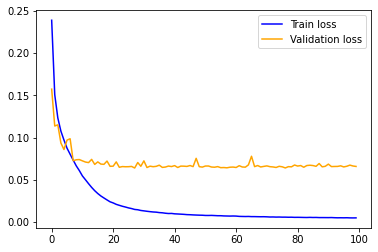

In [14]:
plt.plot(hist.history['loss'], color='blue', label='Train loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation loss')
plt.legend()
plt.show()

In [15]:
print(X_val.shape)

(494, 96, 96, 1)


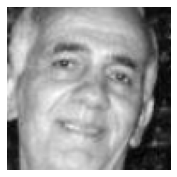

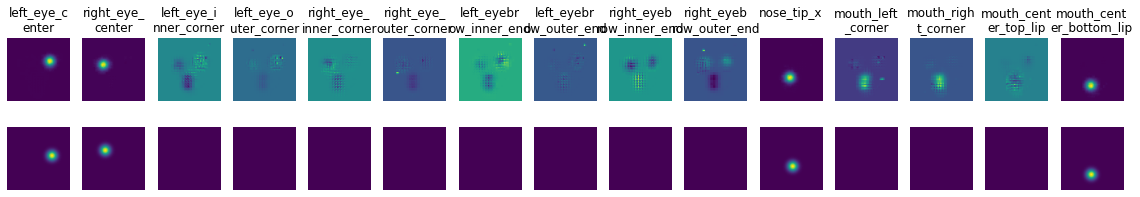

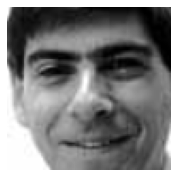

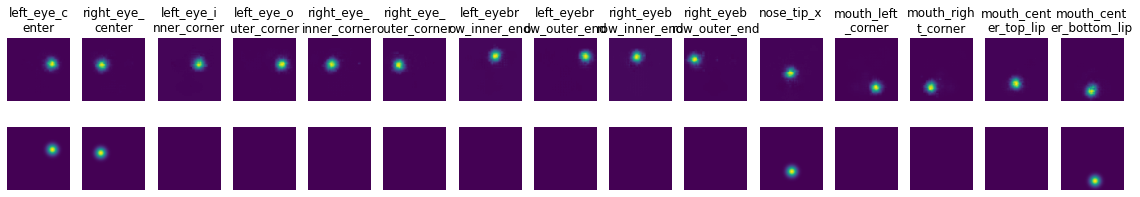

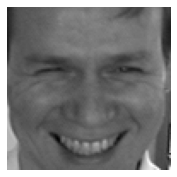

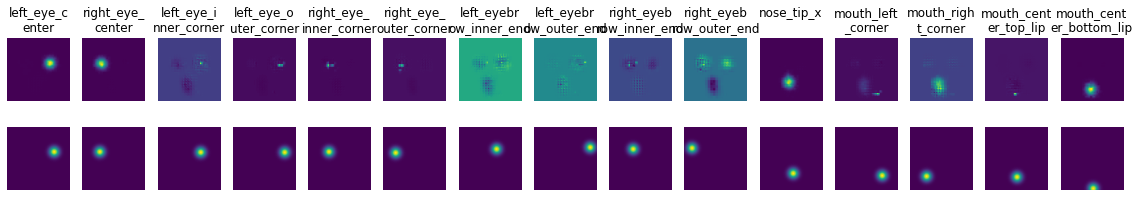

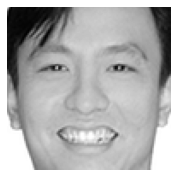

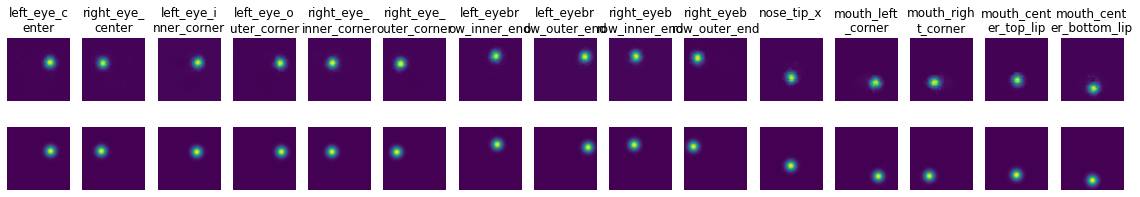

In [16]:
y_pred = model.predict(X_val)
y_pred = y_pred.reshape(-1,output_height,output_width,nClasses)

Nlandmark = y_pred.shape[-1]
for i in range(96,100):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(X_tra[i,:,:,0],cmap="gray")
    ax.axis("off")
    
    fig = plt.figure(figsize=(20,3))
    count = 1
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nlandmark,count)
        ax.set_title(lab[:10] + "\n" + lab[10:-2])
        ax.axis("off")
        count += 1
        ax.imshow(y_pred[i,:,:,j])
        if j == 0:
            ax.set_ylabel("prediction")
            
    for j, lab in enumerate(nm_landmarks[::2]):
        ax = fig.add_subplot(2,Nlandmark,count)
        count += 1
        ax.imshow(y_tra[i,:,:,j])   
        ax.axis("off")
        if j == 0:
            ax.set_ylabel("true")
    plt.show()

C:\Users\MatiX\AppData\Local\Temp\ipykernel_12960\682111637.py:34: RuntimeWarning: invalid value encountered in double_scalars
  i0 /= hsum
C:\Users\MatiX\AppData\Local\Temp\ipykernel_12960\682111637.py:35: RuntimeWarning: invalid value encountered in double_scalars
  i1 /= hsum


n_points to evaluate (x,y) coordinates = 1
 RMSE
  (x,y) from est heatmap  VS (x,y) from true heatmap:10.396
  (x,y) from est heatmap  VS true (x,y)             :10.392
  (x,y) from true heatmap VS true (x,y)             :0.288
n_points to evaluate (x,y) coordinates = 4
 RMSE
  (x,y) from est heatmap  VS (x,y) from true heatmap:10.467
  (x,y) from est heatmap  VS true (x,y)             :10.468
  (x,y) from true heatmap VS true (x,y)             :0.195
n_points to evaluate (x,y) coordinates = 9
 RMSE
  (x,y) from est heatmap  VS (x,y) from true heatmap:10.515
  (x,y) from est heatmap  VS true (x,y)             :10.516
  (x,y) from true heatmap VS true (x,y)             :0.135
n_points to evaluate (x,y) coordinates = 16
 RMSE
  (x,y) from est heatmap  VS (x,y) from true heatmap:10.448
  (x,y) from est heatmap  VS true (x,y)             :10.447
  (x,y) from true heatmap VS true (x,y)             :0.115
n_points to evaluate (x,y) coordinates = 25
 RMSE
  (x,y) from est heatmap  VS (x,y) fr

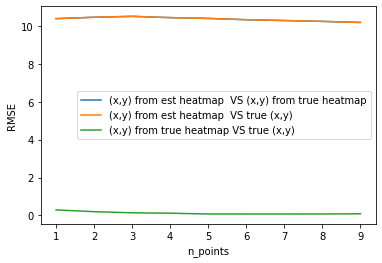

In [17]:
def get_ave_xy(hmi, n_points = 4, thresh=0):
    '''
    hmi      : heatmap np array of size (height,width)
    n_points : x,y coordinates corresponding to the top  densities to calculate average (x,y) coordinates
    
    
    convert heatmap to (x,y) coordinate
    x,y coordinates corresponding to the top  densities 
    are used to calculate weighted average of (x,y) coordinates
    the weights are used using heatmap
    
    if the heatmap does not contain the probability > 
    then we assume there is no predicted landmark, and 
    x = -1 and y = -1 are recorded as predicted landmark.
    '''
    if n_points < 1:
        ## Use all
        hsum, n_points = np.sum(hmi), len(hmi.flatten())
        ind_hmi = np.array([range(input_width)]*input_height)
        i1 = np.sum(ind_hmi * hmi)/hsum
        ind_hmi = np.array([range(input_height)]*input_width).T
        i0 = np.sum(ind_hmi * hmi)/hsum
    else:
        ind = hmi.argsort(axis=None)[-n_points:] ## pick the largest n_points
        topind = np.unravel_index(ind, hmi.shape)
        index = np.unravel_index(hmi.argmax(), hmi.shape)
        i0, i1, hsum = 0, 0, 0
        for ind in zip(topind[0],topind[1]):
            h  = hmi[ind[0],ind[1]]
            hsum += h
            i0   += ind[0]*h
            i1   += ind[1]*h

        i0 /= hsum
        i1 /= hsum
    if hsum/n_points <= thresh:
        i0, i1 = -1, -1
    return([i1,i0])

def transfer_xy_coord(hm, n_points = 64, thresh=0.2):
    '''
    hm : np.array of shape (height,width, n-heatmap)
    
    transfer heatmap to (x,y) coordinates
    
    the output contains np.array (Nlandmark * 2,) 
    * 2 for x and y coordinates, containing the landmark location.
    '''
    assert len(hm.shape) == 3
    Nlandmark = hm.shape[-1]
    #est_xy = -1*np.ones(shape = (Nlandmark, 2))
    est_xy = []
    for i in range(Nlandmark):
        hmi = hm[:,:,i]
        est_xy.extend(get_ave_xy(hmi, n_points, thresh))
    return(est_xy) ## (Nlandmark * 2,) 

def transfer_target(y_pred, thresh=0, n_points = 64):
    '''
    y_pred : np.array of the shape (N, height, width, Nlandmark)
    
    output : (N, Nlandmark * 2)
    '''
    y_pred_xy = []
    for i in range(y_pred.shape[0]):
        hm = y_pred[i]
        y_pred_xy.append(transfer_xy_coord(hm,n_points, thresh))
    return(np.array(y_pred_xy))

def getRMSE(y_pred_xy,y_train_xy,pick_not_NA):
    res = y_pred_xy[pick_not_NA] - y_train_xy[pick_not_NA]
    RMSE = np.sqrt(np.mean(res**2))
    return(RMSE)
nimage = 300 

rmelabels = ["(x,y) from est heatmap  VS (x,y) from true heatmap", 
             "(x,y) from est heatmap  VS true (x,y)             ",
             "(x,y) from true heatmap VS true (x,y)             "]
n_points_width = range(1,10)
res = []
n_points_final, min_rmse  = -1 , np.Inf
for nw in  n_points_width:
    n_points = nw * nw
    y_pred_xy = transfer_target(y_pred[:nimage],0,n_points)
    y_train_xy = transfer_target(y_tra[:nimage],0,n_points)
    pick_not_NA = (y_train_xy != -1)
    
    ts = [getRMSE(y_pred_xy,y_train_xy,pick_not_NA)]
    ts.append(getRMSE(y_pred_xy,y_train0.values[:nimage],pick_not_NA))
    ts.append(getRMSE(y_train_xy,y_train0.values[:nimage],pick_not_NA))
    
    res.append(ts)
    
    print("n_points to evaluate (x,y) coordinates = {}".format(n_points))
    print(" RMSE")
    for r, lab in zip(ts,rmelabels):
        print("  {}:{:5.3f}".format(lab,r))
    
    if min_rmse > ts[2]:
        min_rmse = ts[2]
        n_points_final = n_points
        
res = np.array(res)
for i, lab in enumerate(rmelabels):
    plt.plot(n_points_width, res[:,i], label = lab)
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("n_points")
plt.show()